In [5]:
import os
from scipy.io import loadmat
import h5py

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load mat file data
mat = h5py.File(os.path.join("NYUv2", "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)

# Images are in 4D array (1449, 3, 640, 480), and depth maps are in 3D array (1449, 640, 480).
# We can simply transpose the axes to get them in a format suitable for training.

images = np.transpose(mat["images"], (0, 2, 3, 1))
depths = np.transpose(mat["depths"], (0, 2, 1))

# Shuffle data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
depths = depths[indices]

# Split data into training and validation
train_images = images[:1000]
train_depths = depths[:1000]
val_images = images[1000:]
val_depths = depths[1000:]

In [6]:
def crop_images(images, percentage):
    # The percentage should be between 0 and 1
    height, width = images.shape[1], images.shape[2]
    start_row = int(height * percentage / 2)
    end_row = height - start_row
    start_col = int(width * percentage / 2)
    end_col = width - start_col
    return images[:, start_row:end_row, start_col:end_col, :]

percentage = 0.50  

# Crop training images
train_images = crop_images(train_images, percentage)
val_images = crop_images(val_images, percentage)


In [7]:
print(train_images[0].shape)

(320, 240, 3)


In [8]:
# Extract depth value at the center
center_depths_train = train_depths[:, 320, 240]
center_depths_val = val_depths[:, 320, 240]

# normalize images for better network performance
train_images = train_images / 255.
val_images = val_images / 255.

# Reshape depths for suitable training 
center_depths_train = center_depths_train.reshape(-1, 1)
center_depths_val = center_depths_val.reshape(-1, 1)

In [9]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# We'll need to resize our images to fit the Xception model input shape
train_images_resized = tf.image.resize(train_images, [299, 299])
val_images_resized = tf.image.resize(val_images, [299, 299])

# Base Xception model, pre-trained on imagenet
base_model = Xception(weights='imagenet', include_top=False)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Define new top layers (you can adjust the architecture as needed)
x = base_model.output
x = GlobalAveragePooling2D()(x)  # This layer is often used after the convolutional layers in deep networks
output_layer = Dense(1, activation='linear')(x)  # Use linear activation for regression tasks

# Construct the full model
model = Model(inputs=base_model.input, outputs=output_layer)

83683744/83683744 [==============================] - 3s 0us/step


In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(train_images_resized, center_depths_train, 
                    validation_data=(val_images_resized, center_depths_val), 
                    epochs=20)

Epoch 1/20
32/32 [==============================] - 9s 109ms/step - loss: 2.0650 - val_loss: 1.2813
Epoch 2/20
32/32 [==============================] - 3s 87ms/step - loss: 1.0926 - val_loss: 1.1613
Epoch 3/20
32/32 [==============================] - 3s 86ms/step - loss: 0.9644 - val_loss: 1.1102
Epoch 4/20
32/32 [==============================] - 3s 86ms/step - loss: 0.9041 - val_loss: 1.0752
Epoch 5/20
32/32 [==============================] - 3s 86ms/step - loss: 0.8538 - val_loss: 1.0554
Epoch 6/20
32/32 [==============================] - 3s 86ms/step - loss: 0.8158 - val_loss: 1.0393
Epoch 7/20
32/32 [==============================] - 3s 86ms/step - loss: 0.7812 - val_loss: 1.0247
Epoch 8/20
32/32 [==============================] - 3s 86ms/step - loss: 0.7552 - val_loss: 1.0188
Epoch 9/20
32/32 [==============================] - 3s 87ms/step - loss: 0.7318 - val_loss: 1.0171
Epoch 10/20
32/32 [==============================] - 3s 87ms/step - loss: 0.7048 - val_loss: 1.0207
Epoch 11

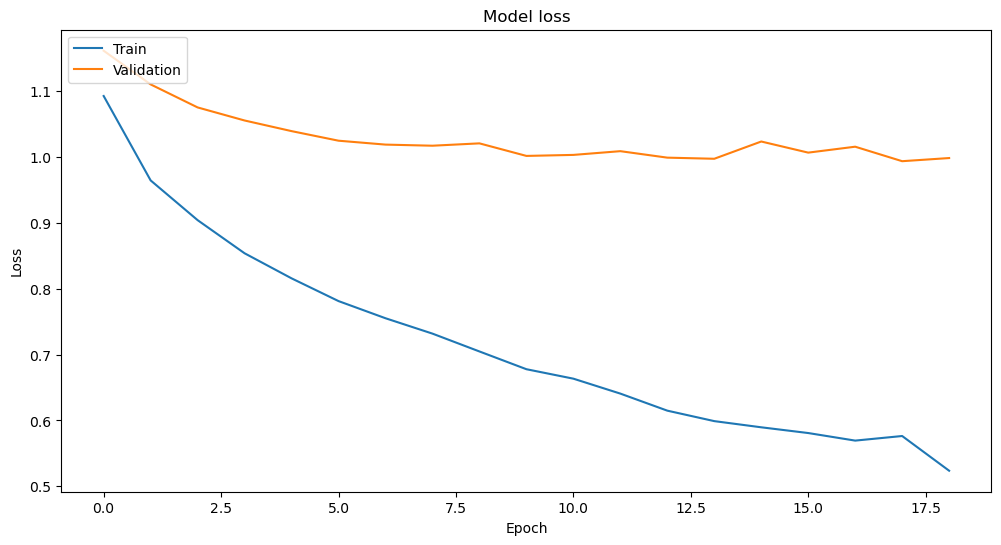

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")


15/15 [==============================] - 2s 49ms/step
Mean Absolute Error (MAE): 0.7919463515281677 meters
Mean Squared Error (MSE): 1.023569107055664 meters


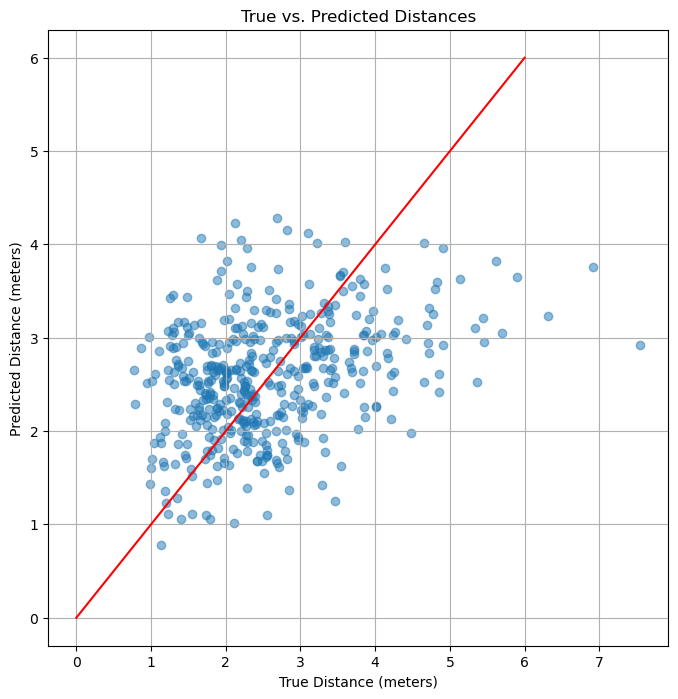

In [13]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()


In [14]:
model.save('distance_prediction_Xception.h5')

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('distance_prediction_Xception.h5')

In [11]:
from tensorflow.keras.optimizers import Adam

train_images_resized = tf.image.resize(train_images, [299, 299])
val_images_resized = tf.image.resize(val_images, [299, 299])

# Define the layer from which you want to start fine-tuning
fine_tune_from = 'block14_sepconv1'

# Unfreeze all the layers after the 'fine_tune_from' layer
do_fine_tuning = False
for layer in model.layers:
    if layer.name == fine_tune_from:
        do_fine_tuning = True
    if do_fine_tuning:
        layer.trainable = True
    else:
        layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Continue training
history = model.fit(train_images_resized, center_depths_train, 
                         validation_data=(val_images_resized, center_depths_val), 
                         epochs=20)


Epoch 1/20
32/32 [==============================] - 5s 112ms/step - loss: 0.0556 - val_loss: 0.6395
Epoch 2/20
32/32 [==============================] - 3s 92ms/step - loss: 0.1095 - val_loss: 0.6241
Epoch 3/20
32/32 [==============================] - 3s 92ms/step - loss: 0.0728 - val_loss: 0.6192
Epoch 4/20
32/32 [==============================] - 3s 91ms/step - loss: 0.0545 - val_loss: 0.6330
Epoch 5/20
32/32 [==============================] - 3s 92ms/step - loss: 0.0567 - val_loss: 0.6199
Epoch 6/20
32/32 [==============================] - 3s 92ms/step - loss: 0.0536 - val_loss: 0.6118
Epoch 7/20
32/32 [==============================] - 3s 92ms/step - loss: 0.0564 - val_loss: 0.6397
Epoch 8/20
32/32 [==============================] - 3s 93ms/step - loss: 0.0533 - val_loss: 0.6322
Epoch 9/20
32/32 [==============================] - 3s 94ms/step - loss: 0.0553 - val_loss: 0.6003
Epoch 10/20
32/32 [==============================] - 3s 93ms/step - loss: 0.0412 - val_loss: 0.6150
Epoch 11

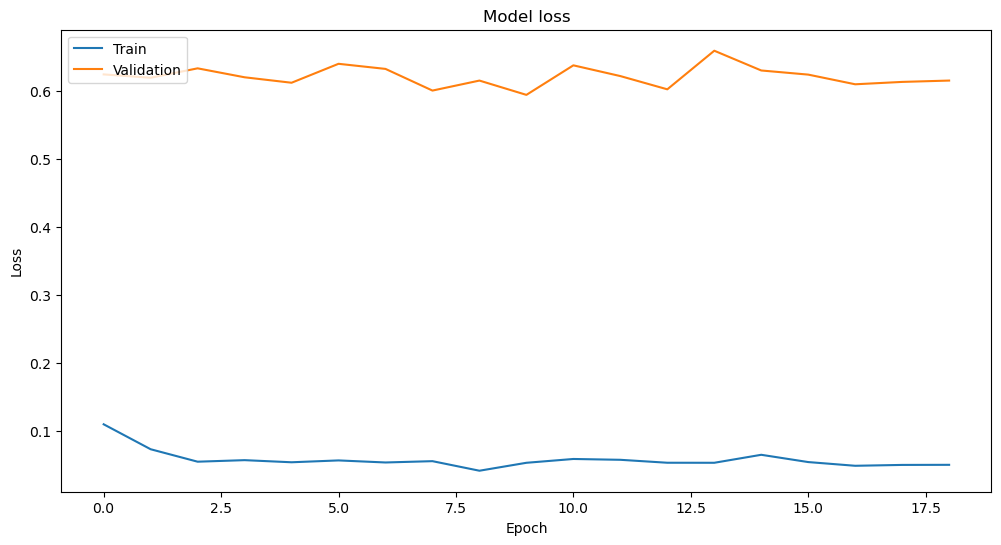

In [12]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_images)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)
true_values = center_depths_val.reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters")

15/15 [==============================] - 1s 49ms/step
Mean Absolute Error (MAE): 0.6541799306869507 meters
Mean Squared Error (MSE): 0.714726984500885 meters


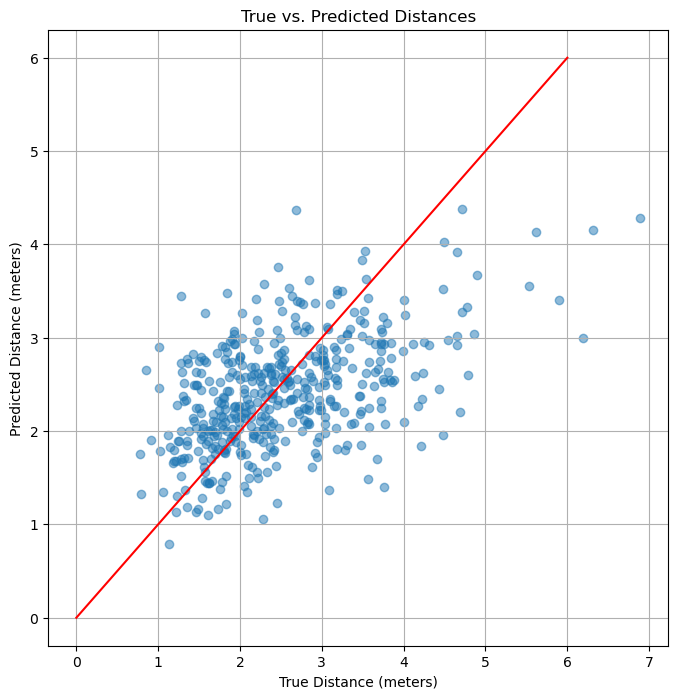

In [14]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values, val_predictions, alpha=0.5)
plt.plot([0, 6], [0, 6], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()
